In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.convtools import conviter
from deepmeg.models.interpretable import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.interpreters import SPIRITInterpreter
import random


In [2]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

from deepmeg.models import BaseModel

class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))

        self.a0 = nn.Parameter(torch.empty(1))


        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = self.a0/(2*self.n_points)*torch.ones_like(x)
        for n in range(self.n_components):
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components=None):
        super().__init__()

        if n_components is None:
            n_components = n_points//2

        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

from deepmeg.convtools import compute_output_shape, conviter

class AutoCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        # self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))
        self.transform = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])
        self.transform2 = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # init.uniform_(self.weight, -0.01, 0.01)
        if self.bias is not None:
            init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, len(self.transform)) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(len(self.transform)):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                pad_params = list()

                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                if window_range.start is not None and abs(window_range.start) < self.window_size:
                    pad_params.append(abs(window_range.start))
                else:
                    pad_params.append(0)
                if window_range.stop is not None and abs(window_range.stop) < self.window_size:
                    pad_params.append(abs(window_range.stop))
                else:
                    pad_params.append(0)

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]

                if pad_params != [0, 0]:
                    window1 = nn.functional.pad(window1, pad_params)
                    window2 = nn.functional.pad(window2, pad_params)

                # weight = self.weight[window_range, :, n_neuron]

                # proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                # proj2 = torch.matmul(window2, weight)
                proj1 = self.transform[n_neuron](window1)
                proj2 = self.transform2[n_neuron](window2)

                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)

        return out_tensor

# X = torch.rand(100, 204)
# AutoCov1D(1, 20, 20, 0, 20, 10)(X)


class SPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                AutoCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


# SPIRIT(
#     **model_kwargs
# )(X)

In [3]:
def generate_activations(
    event_names, roi_labels, n_rois=1
):
    start = 0
    random.shuffle(roi_labels)
    activations = dict()

    for event in event_names:
        n_rois_sel = int(np.random.randint(1, n_rois+1))
        sel_rois = roi_labels[start:start+n_rois_sel]
        activations[event] = [(sel_roi.name, int(np.random.randint(10, 100))) for sel_roi in sel_rois]
        start += n_rois_sel

        if start >= len(roi_labels):
            break

    return activations


def plot_roi(roi_labels, subject, subjects_dir, colors=None, marker_sizes=None):
    coords = list()
    for roi_label in roi_labels:
        if roi_label.name[-2:] == 'lh':
            hemi = 0
        elif roi_label.name[-2:] == 'rh':
            hemi = 1
        else: raise ValueError(f'Hemisphere undefined: {roi_label.name}')

        coords.append(
            mne.vertex_to_mni(
                roi_label.center_of_mass(
                    subject,
                    subjects_dir=subjects_dir
                ),
                hemi,
                subject,
                subjects_dir=subjects_dir
            )
        )
    if isinstance(colors, str):
        colors = [colors for _ in coords]
    view = plotting.view_markers(
        coords, colors,
        marker_size=marker_sizes
    )
    return view


def data_fun(times, latency, duration, rng=None, f = 15):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    if not rng:
        rng = np.random.RandomState(7)
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf


# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [4]:
from collections import namedtuple

EventConfig = namedtuple('EventConfig', 'start duration id')


def create_events(*configs: EventConfig, duration, sfreq):
    n_points = int(duration*sfreq)
    all_events = list()
    for config in configs:
        currect_timepoint = int(config.start*sfreq)
        events = list()
        while currect_timepoint < n_points:
            events.append([currect_timepoint, 0, config.id])
            currect_timepoint += int(config.duration*sfreq)
        all_events += events
    all_events = np.array(all_events)
    return all_events[np.argsort(all_events[:, 0])]


In [12]:
events[:, 0][-1]/info_orig['sfreq']

280.83215161543

In [5]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_info = meg_path / 'sample_audvis_raw.fif'
info_orig = mne.io.read_raw_fif(fname_info).resample(600).info#read_info(fname_info)
tstep = 1 / info_orig['sfreq']
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

# events = mne.read_events(fname_event)

events = create_events(
    EventConfig(10., 2., 1),
    EventConfig(11., 2., 2),
    # EventConfig(10.5, 1., 3),
    duration=300,
    sfreq=info_orig['sfreq']
)

noise_cov = mne.read_cov(fname_cov)

# event_id = {'e1': 1, 'e2': 2, 'e3': 3,
#             'e4': 4, 'e5': 5, 'e6': 32}
# event_id = {'e1': 1, 'e2': 2, 'e3': 3}

all_labels = mne.read_labels_from_annot('sample', parc='aparc.a2009s', subjects_dir=subjects_dir)
label_by_name = {label.name: label for label in all_labels}


In [160]:
label_by_name.keys()

dict_keys(['G_Ins_lg_and_S_cent_ins-lh', 'G_Ins_lg_and_S_cent_ins-rh', 'G_and_S_cingul-Ant-lh', 'G_and_S_cingul-Ant-rh', 'G_and_S_cingul-Mid-Ant-lh', 'G_and_S_cingul-Mid-Ant-rh', 'G_and_S_cingul-Mid-Post-lh', 'G_and_S_cingul-Mid-Post-rh', 'G_and_S_frontomargin-lh', 'G_and_S_frontomargin-rh', 'G_and_S_occipital_inf-lh', 'G_and_S_occipital_inf-rh', 'G_and_S_paracentral-lh', 'G_and_S_paracentral-rh', 'G_and_S_subcentral-lh', 'G_and_S_subcentral-rh', 'G_and_S_transv_frontopol-lh', 'G_and_S_transv_frontopol-rh', 'G_cingul-Post-dorsal-lh', 'G_cingul-Post-dorsal-rh', 'G_cingul-Post-ventral-lh', 'G_cingul-Post-ventral-rh', 'G_cuneus-lh', 'G_cuneus-rh', 'G_front_inf-Opercular-lh', 'G_front_inf-Opercular-rh', 'G_front_inf-Orbital-lh', 'G_front_inf-Orbital-rh', 'G_front_inf-Triangul-lh', 'G_front_inf-Triangul-rh', 'G_front_middle-lh', 'G_front_middle-rh', 'G_front_sup-lh', 'G_front_sup-rh', 'G_insular_short-lh', 'G_insular_short-rh', 'G_oc-temp_lat-fusifor-lh', 'G_oc-temp_lat-fusifor-rh', 'G_oc-t

In [6]:
activations = {
    'e1': [
        ('S_interm_prim-Jensen-rh', 5),
        ('S_oc-temp_lat-rh', 5),
        # ('S_oc-temp_med_and_Lingual-rh', 20),
        # ('S_intrapariet_and_P_trans-rh', 5),
        # ('S_oc_middle_and_Lunatus-rh', 5),
        # ('G_temporal_middle-rh', 5),
    ],
    'e2': [
        # ('S_circular_insula_inf-rh', 5),
        ('S_interm_prim-Jensen-rh', 5),
        ('S_oc-temp_lat-rh', 5),
        # ('S_oc-temp_med_and_Lingual-rh', 20),
        # ('G_temporal_middle-rh', 5),
    ],
    # 'e3': [
    #     ('S_circular_insula_inf-rh', 2),
    #     ('S_oc-temp_med_and_Lingual-rh', 20),
    #     # ('S_collat_transv_post-rh', 8)
    #     # ('G_orbital-rh', 70)
    # ],
    # 'e4': [('S_pericallosal-rh', 30), ('S_calcarine-rh', 43)],
    # 'e5': [('G_front_inf-Opercular-rh', 22), ('S_circular_insula_sup-lh', 23)],
    # 'e6': [('S_circular_insula_sup-rh', 58), ('G_cuneus-lh', 23)]
}

In [28]:
new_activations = generate_activations(
    [
        'e4',
        'e5', 'e6'
    ], all_labels, 8
)
# all_activations = dict(**activations, **new_activations)


In [7]:
all_activations = activations
labels = list()
marker_sizes = list()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
all_colors = list()
for color, (event_name, activation) in zip(colors, all_activations.items()):
    for a in activation:
        labels.append(label_by_name[a[0]])
        marker_sizes.append(a[1])
        all_colors.append(color)

plot_roi(labels, 'sample', subjects_dir, all_colors, marker_sizes)

In [8]:
annot = 'aparc.a2009s'
label_names = sorted(set(activation[0]
                         for activation_list in all_activations.values()
                         for activation in activation_list))
region_names = list(all_activations.keys())

In [9]:
times = np.arange(600, dtype=np.float64) / info_orig['sfreq']
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

# durations = [0.05, 0.08, 0.1]
# latencies = [0.1, 0.5, 0.8]
# freqs = [10., 20., 30.]

durations = [
    [.2, .2],
    [.2, .2],
    # [.1, .2, .1],
    # [.1, .2, .1]
]
latencies = [
    # [.5, .1, .9],
    # [.5, .1, .9],
    [.2, .5],
    [.8, .5],
]
freqs = [
    # [20., 10., 40],
    # [20., 10., 40],
    [10., 20.],
    [10., 20.]
]

cfg_data = dict()

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(len(all_activations[region_name])):
        label_name = all_activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(
            subject,
            annot,
            subjects_dir=subjects_dir,
            regexp=label_name,
            verbose=False
        )
        label_tmp = label_tmp[0]
        amplitude_tmp = all_activations[region_name][i][1]

        if region_name in activations.keys():
            # duration = np.random.uniform(0.01, 0.1)
            duration = durations[region_id-1][i]
            # latency_tmp = np.random.uniform(0.1, 0.6)
            latency_tmp = latencies[region_id-1][i]
            # f = np.random.uniform(8., 30.)
            f = freqs[region_id-1][i]
        else:
            duration = np.random.uniform(0.01, 0.5)
            latency_tmp = np.random.uniform(0.1, 1.6)
            f = np.random.uniform(8., 30.)

        if region_name not in cfg_data:
            cfg_data[region_name] = dict()

        cfg_data[region_name][label_name] = dict(duration=duration, latency=latency_tmp, frequency=f)
        wf_tmp = data_fun(times, latency_tmp, duration, f=f)
        source_simulator.add_data(
            label_tmp,
            amplitude_tmp * wf_tmp,
            events_tmp
        )

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

In [10]:
for event, eventdict in cfg_data.items():
    print(f'{event}:')
    for region, regiondict in eventdict.items():
        print(f'\t{region}:')
        for param, value in regiondict.items():
            print(f'\t\t{param}: {value}')

e1:
	S_interm_prim-Jensen-rh:
		duration: 0.2
		latency: 0.2
		frequency: 10.0
	S_oc-temp_lat-rh:
		duration: 0.2
		latency: 0.5
		frequency: 20.0
e2:
	S_interm_prim-Jensen-rh:
		duration: 0.2
		latency: 0.8
		frequency: 10.0
	S_oc-temp_lat-rh:
		duration: 0.2
		latency: 0.5
		frequency: 20.0


In [13]:
raw_sim = mne.simulation.simulate_raw(info_orig, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(
    raw_sim,
    cov=noise_cov,
    random_state=0
)
# mne.simulation.add_eog(raw_sim, random_state=0)
# mne.simulation.add_ecg(raw_sim, random_state=0)

# Plot original and simulated raw data.
# %matplotlib inline
# fig = raw_sim.plot(title='Simulated raw data')

<RawArray | 376 x 180000 (300.0 s), ~519.6 MB, data loaded>

In [14]:
event_id = {'e1': 1, 'e2': 2,}

epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=2.,
                    baseline=(None, 0),
                    # event_repeated='drop'
)

In [17]:
epochs.load_data().resample(200).crop(0., None).pick_types(meg='grad')
epochsoi = epochs[['e1', 'e2']]
evo = epochsoi.average(by_event_type=True)

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


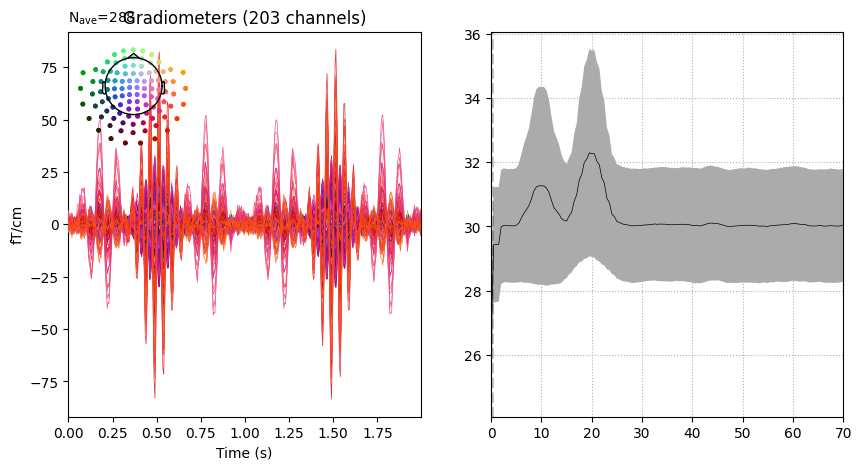

In [18]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochsoi.plot_psd(average=True, ax=ax2, fmax=70)
epochsoi.average().plot(axes=ax1)
plt.show()

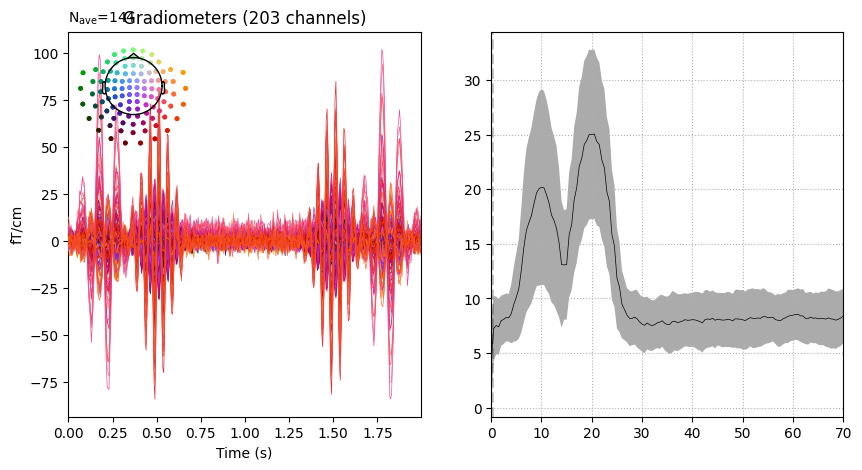

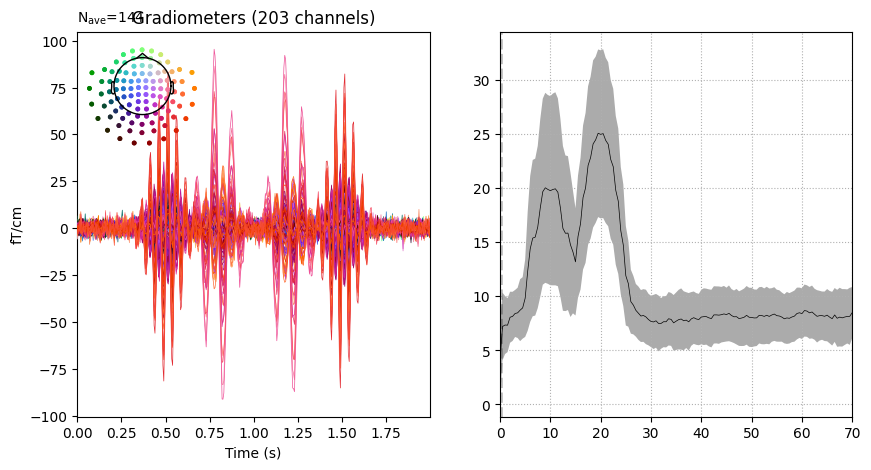

In [42]:
for evoked in evo:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    evoked.plot_psd(average=True, ax=ax2, fmax=70)
    evoked.plot(axes=ax1)
    plt.show()

In [19]:
data = epochsoi.get_data()
labels = epochsoi.events[:, 2]

In [20]:
data.shape

(288, 203, 400)

In [19]:
plt.plot(data.mean((0,1)))

In [20]:
from deepmeg.preprocessing.transforms import one_hot_encoder

In [21]:
data.min()

-1.3072769610490251e-10

In [21]:
dataset = EpochsDataset(
    (
        epochsoi
        # data,
        # one_hot_encoder(labels)
    ),
    savepath='../datasets/simulated_n2',
    transform=zscore
)

In [22]:
dataset.save('../data/simulated_n2.pt')

In [32]:
dataset = read_epochs_dataset('../data/simulated_n2.pt')

In [33]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [34]:
X, y = next(iter(DataLoader(test)))
X.shape

torch.Size([1, 203, 400])

In [24]:
# from mne.datasets import multimodal
# fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(200).pick_types(meg='grad').info

In [35]:
from deepmeg.models.interpretable import LFCNN

lfcnn = LFCNN(
    n_channels=203, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[-1],
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=2 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

lfcnn.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [36]:
lfcnn(X)

tensor([[-0.1456,  0.0843]], grad_fn=<AddmmBackward0>)

Epoch 0:  loss_train:  0.7310   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7228   |    binary_accuracy_val:  0.5761
Epoch 1:  loss_train:  0.7135   |    binary_accuracy_train:  0.5769   |    loss_val:  0.7118   |    binary_accuracy_val:  0.5978
Epoch 2:  loss_train:  0.6961   |    binary_accuracy_train:  0.6474   |    loss_val:  0.7001   |    binary_accuracy_val:  0.6304
Epoch 3:  loss_train:  0.6784   |    binary_accuracy_train:  0.7276   |    loss_val:  0.6872   |    binary_accuracy_val:  0.6522
Epoch 4:  loss_train:  0.6600   |    binary_accuracy_train:  0.7885   |    loss_val:  0.6727   |    binary_accuracy_val:  0.7065
Epoch 5:  loss_train:  0.6404   |    binary_accuracy_train:  0.8109   |    loss_val:  0.6562   |    binary_accuracy_val:  0.7717
Epoch 6:  loss_train:  0.6193   |    binary_accuracy_train:  0.8814   |    loss_val:  0.6376   |    binary_accuracy_val:  0.8261
Epoch 7:  loss_train:  0.5966   |    binary_accuracy_train:  0.9103   |    loss_val:  0.6166   | 

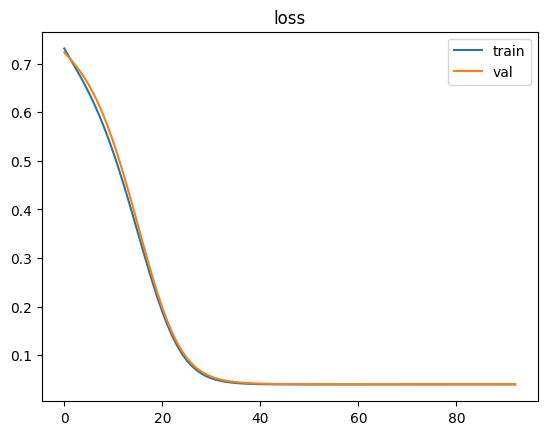

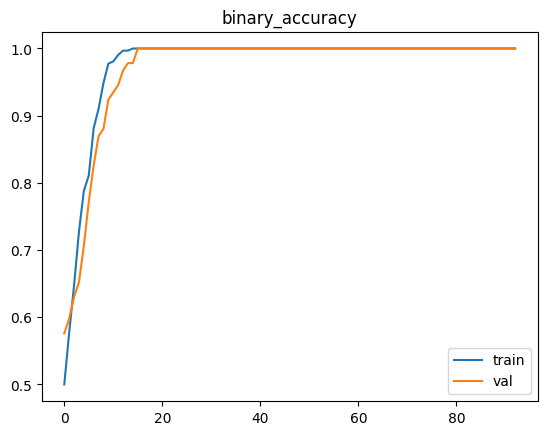

In [37]:
history = lfcnn.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [38]:
train_result = lfcnn.evaluate(train)
result = lfcnn.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.03988728739998557
train_binary_accuracy: 1.0
loss: 0.04016259854490107
binary_accuracy: 1.0


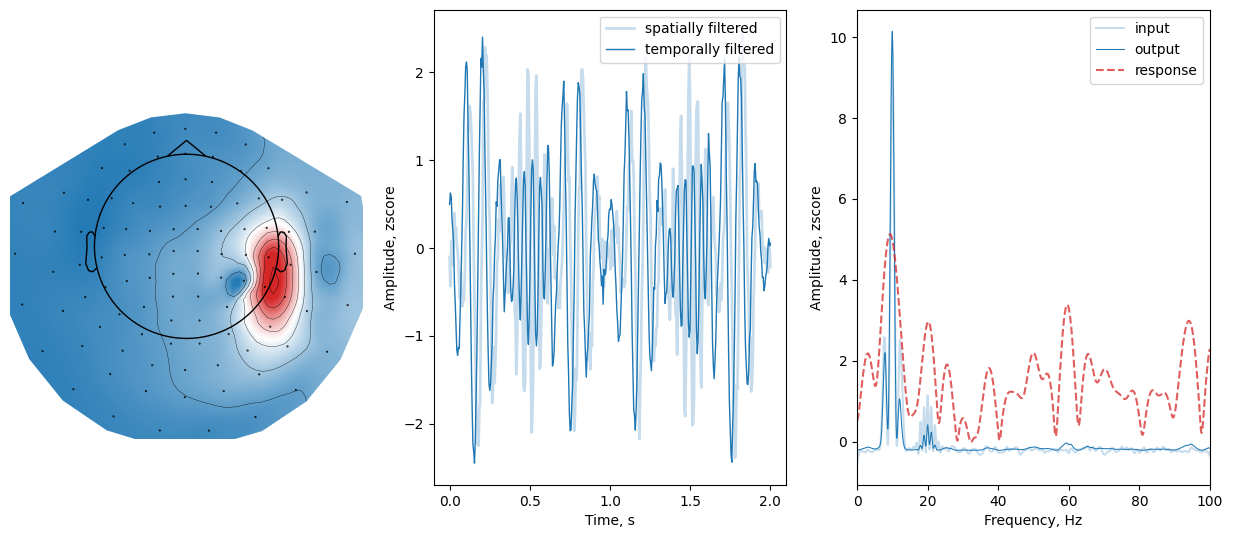

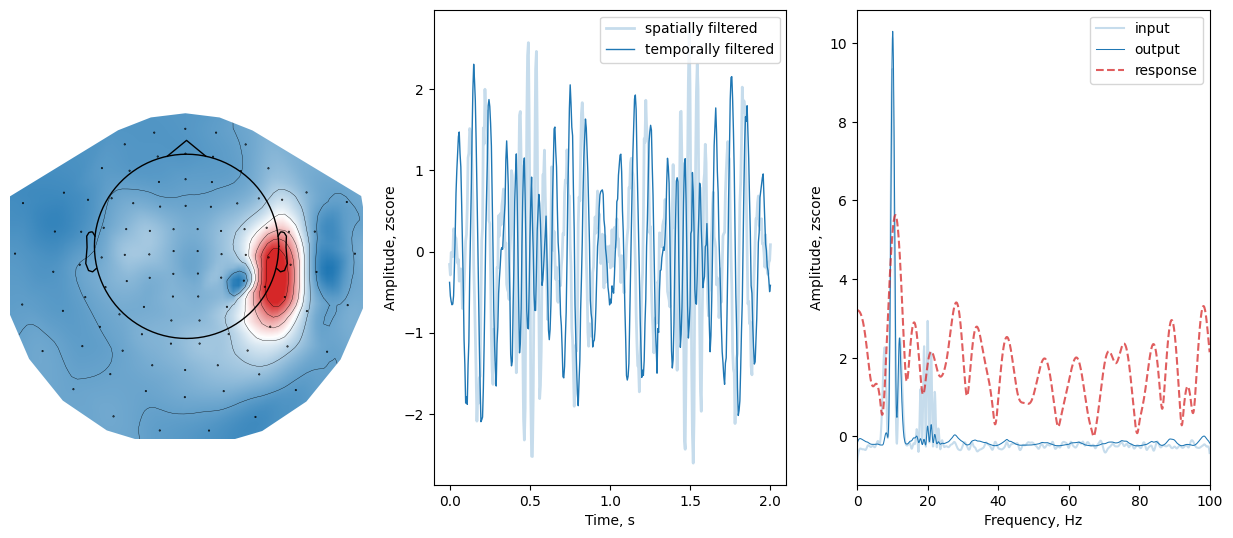

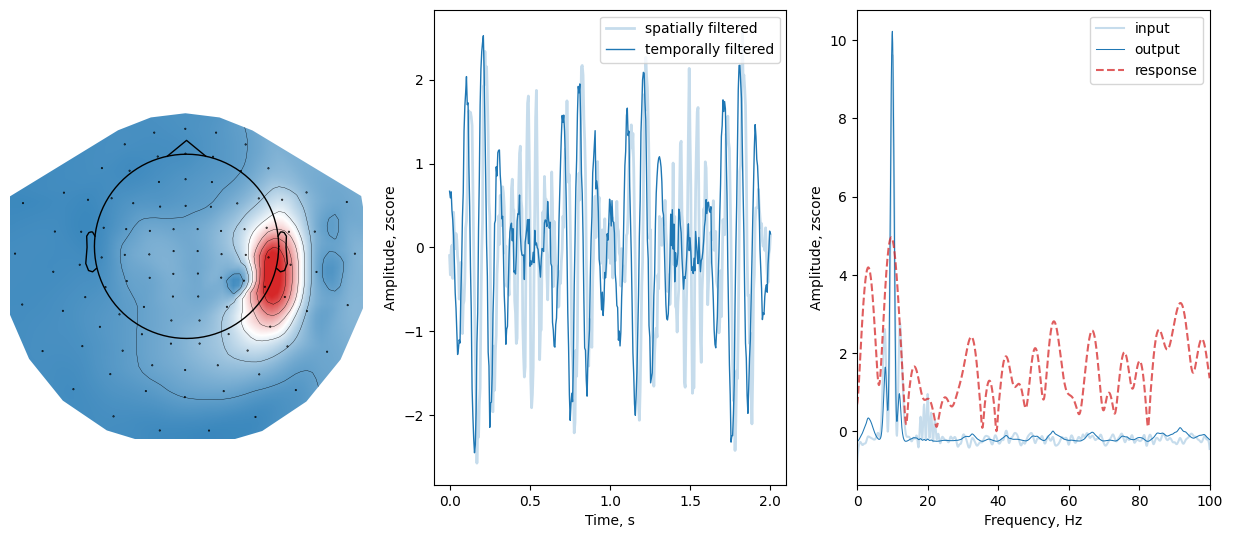

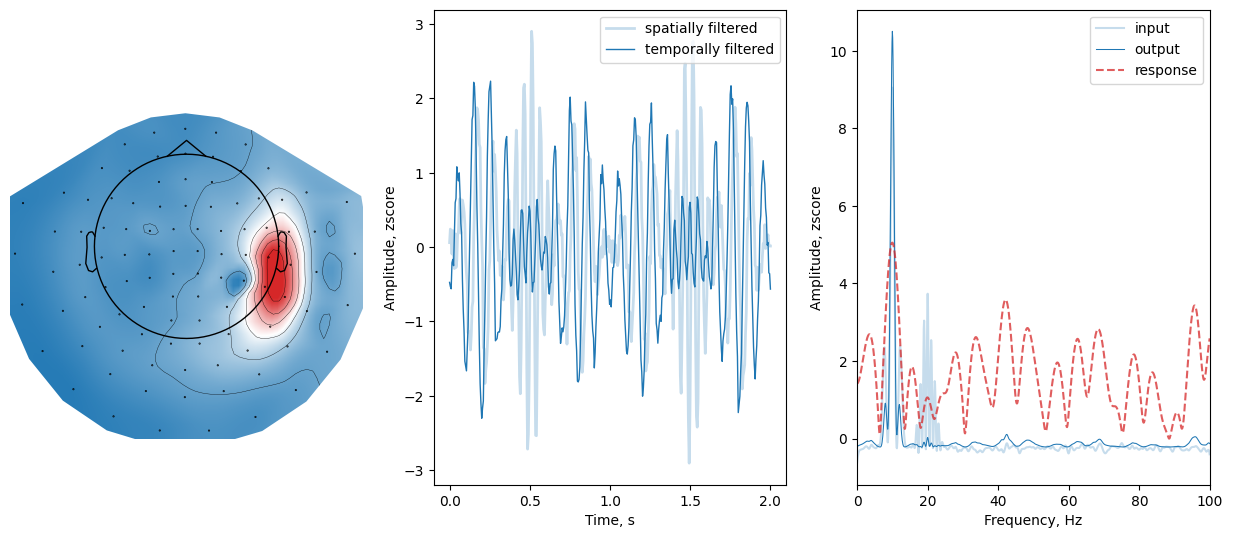

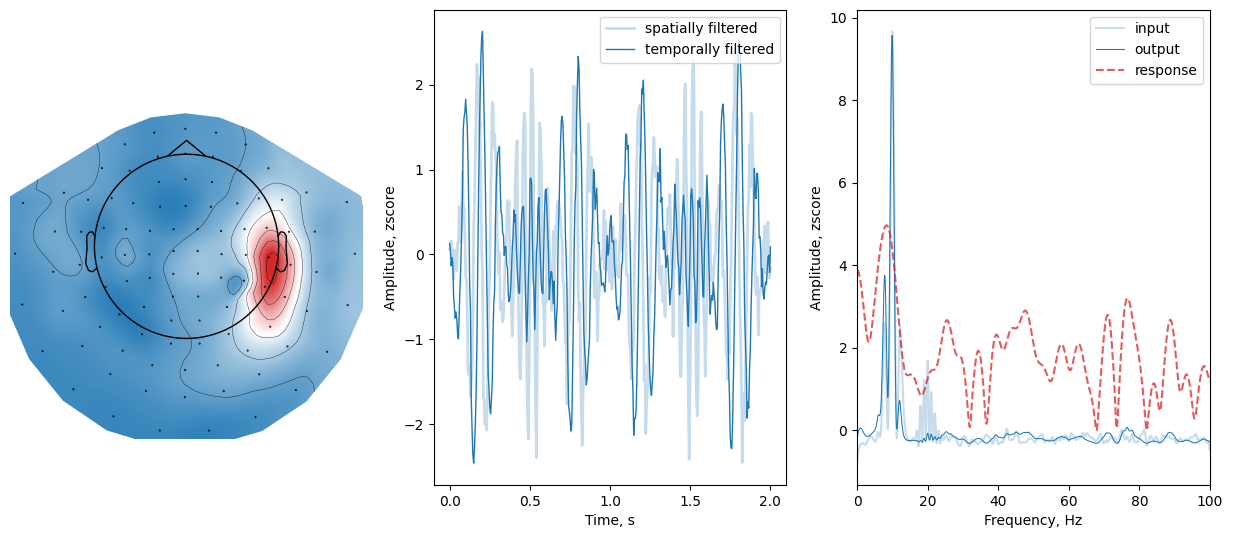

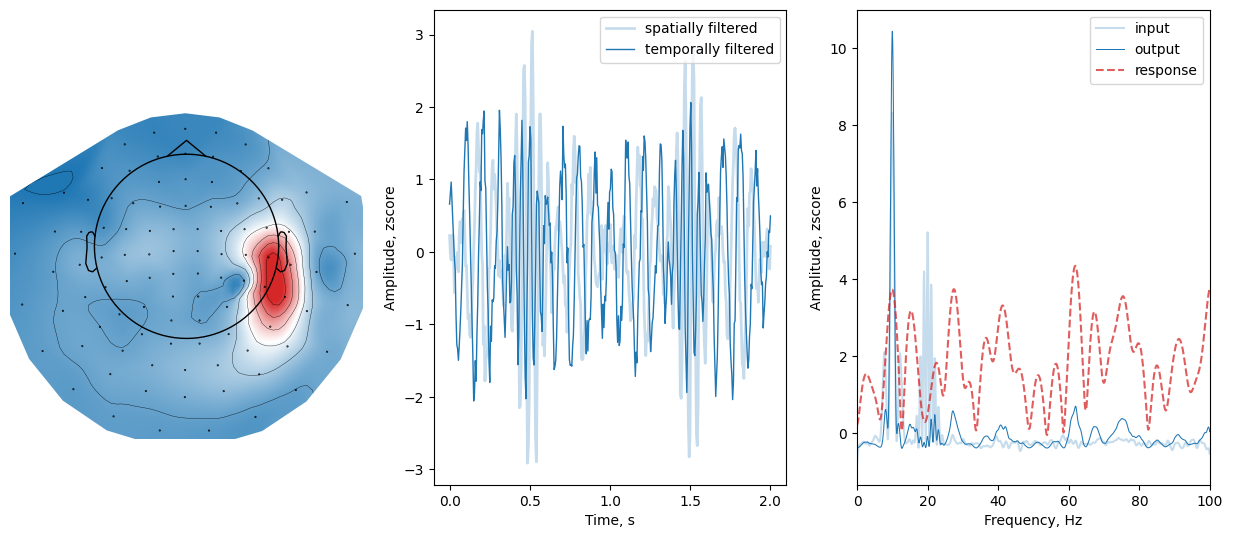

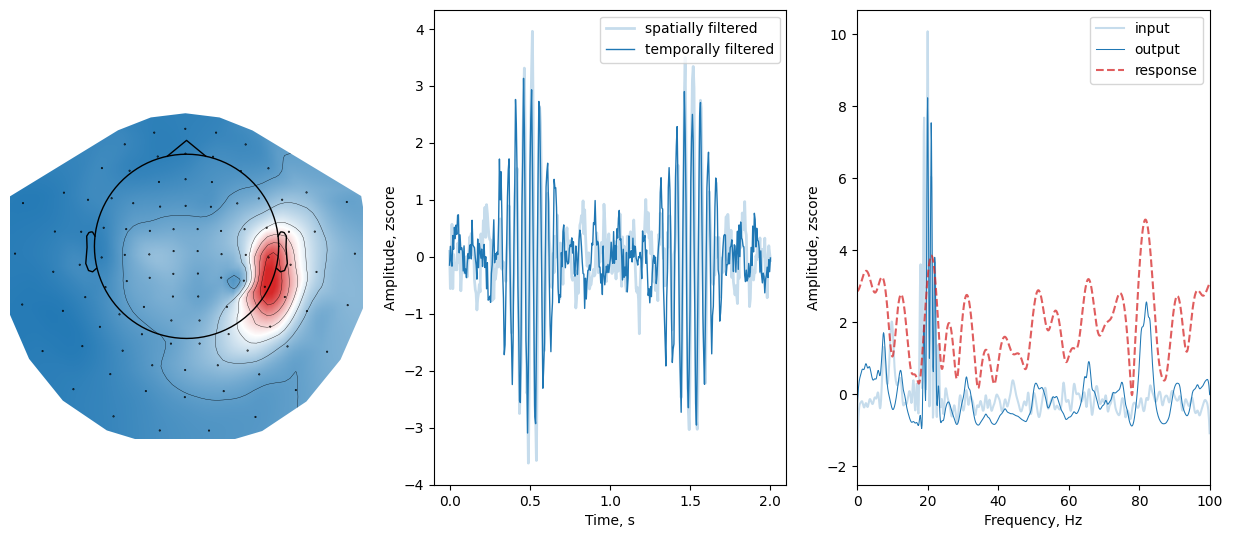

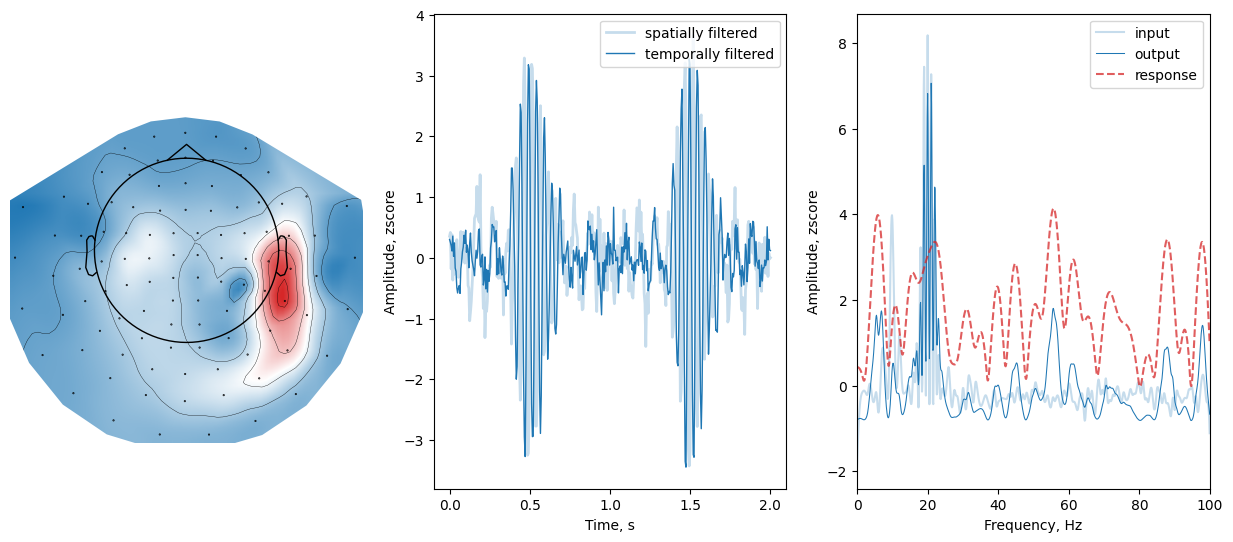

In [40]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNInterpreter(lfcnn, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [47]:
kwargs = dict(
    n_channels=203,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=2
)

spirit = SPIRIT(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

spirit.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        # L2Reg(
        #     [
        #         'unmixing_layer.weight', 'temp_conv.weight',
        #         *[f'timesel_list.{i}.0.transform.0.layer.a' for i in range(8)],
        #         *[f'timesel_list.{i}.0.transform.0.layer.b' for i in range(8)],
        #         *[f'timecomp_list.{i}.0.weight' for i in range(8)],
        #     ], lambdas=[
        #         .01, .01,
        #         *[.01 for _ in range(8)],
        #         *[.01 for _ in range(8)],
        #         *[.01 for _ in range(8)]
        #     ]
        #     # lambdas=.01
        # ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [ ]:
spirit.state_dict().keys()

Epoch 0:  loss_train:  0.6964   |    binary_accuracy_train:  0.5192   |    loss_val:  0.6920   |    binary_accuracy_val:  0.5000
Epoch 1:  loss_train:  0.6929   |    binary_accuracy_train:  0.5000   |    loss_val:  0.6915   |    binary_accuracy_val:  0.5435
Epoch 2:  loss_train:  0.6913   |    binary_accuracy_train:  0.5192   |    loss_val:  0.6922   |    binary_accuracy_val:  0.5000
Epoch 3:  loss_train:  0.6915   |    binary_accuracy_train:  0.5000   |    loss_val:  0.6920   |    binary_accuracy_val:  0.5000
Epoch 4:  loss_train:  0.6910   |    binary_accuracy_train:  0.5000   |    loss_val:  0.6902   |    binary_accuracy_val:  0.5000
Epoch 5:  loss_train:  0.6887   |    binary_accuracy_train:  0.5000   |    loss_val:  0.6879   |    binary_accuracy_val:  0.6957
Epoch 6:  loss_train:  0.6860   |    binary_accuracy_train:  0.7372   |    loss_val:  0.6858   |    binary_accuracy_val:  0.5435
Epoch 7:  loss_train:  0.6835   |    binary_accuracy_train:  0.5192   |    loss_val:  0.6834   | 

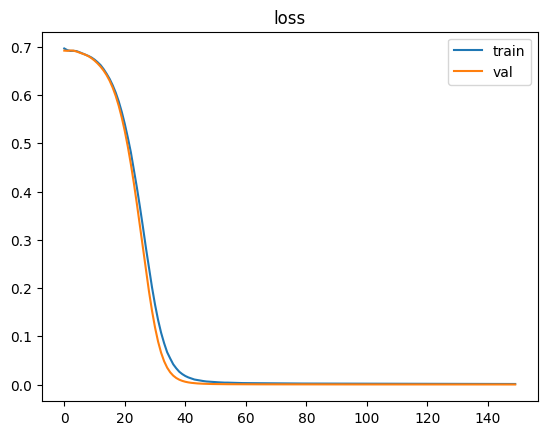

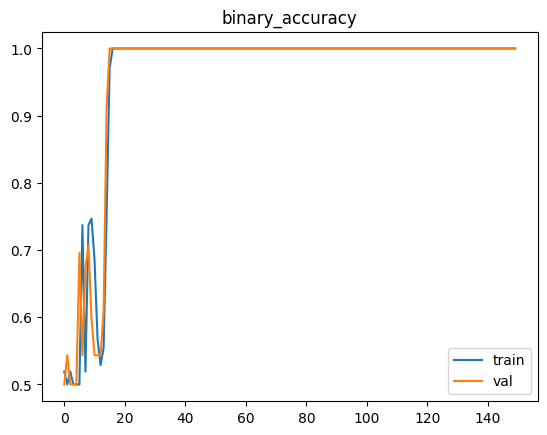

In [48]:
history = spirit.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [49]:
train_result = spirit.evaluate(train)
result = spirit.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.00012528105435194448
train_binary_accuracy: 1.0
loss: 0.00012713148912139744
binary_accuracy: 1.0


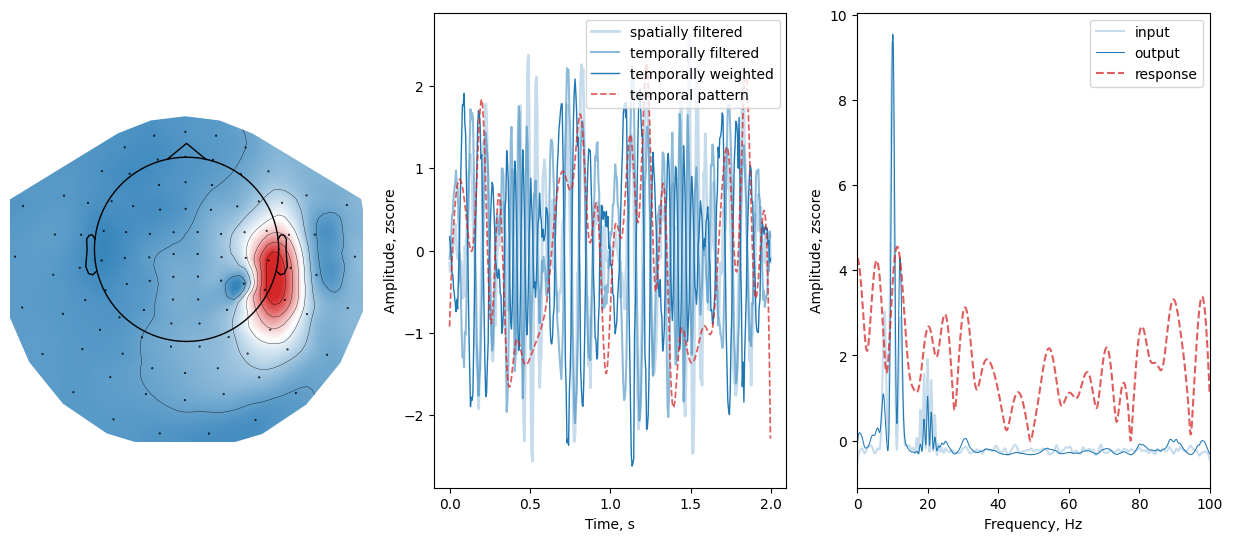

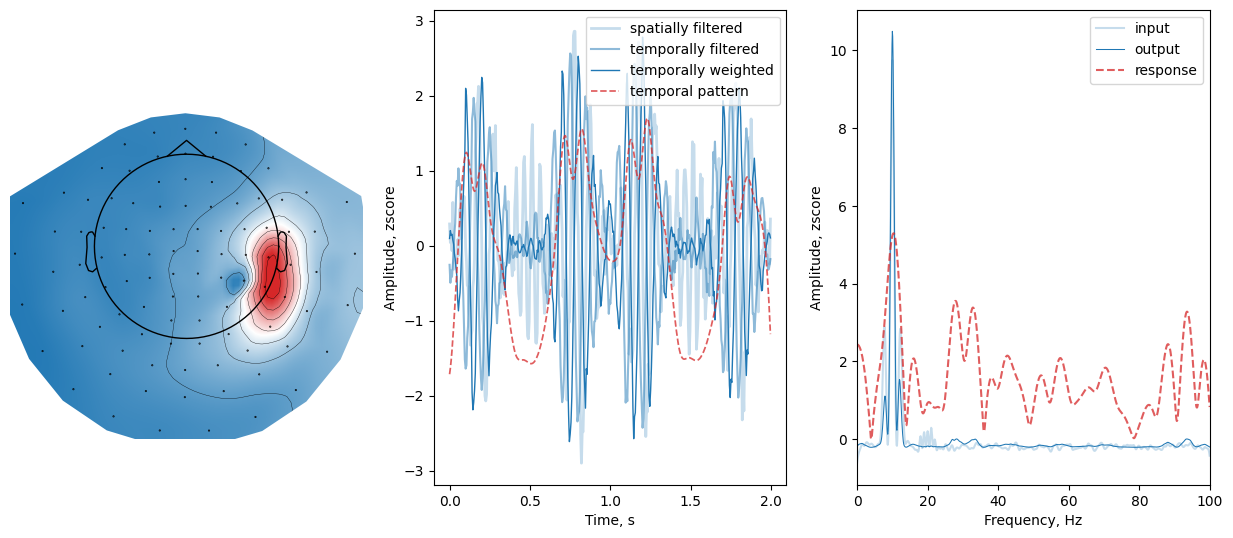

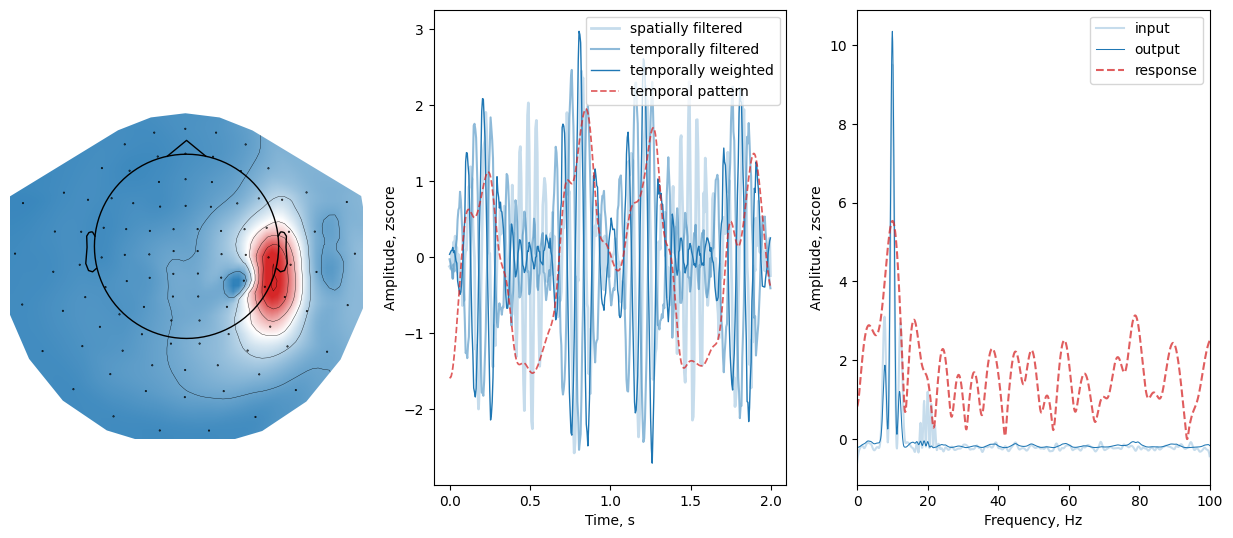

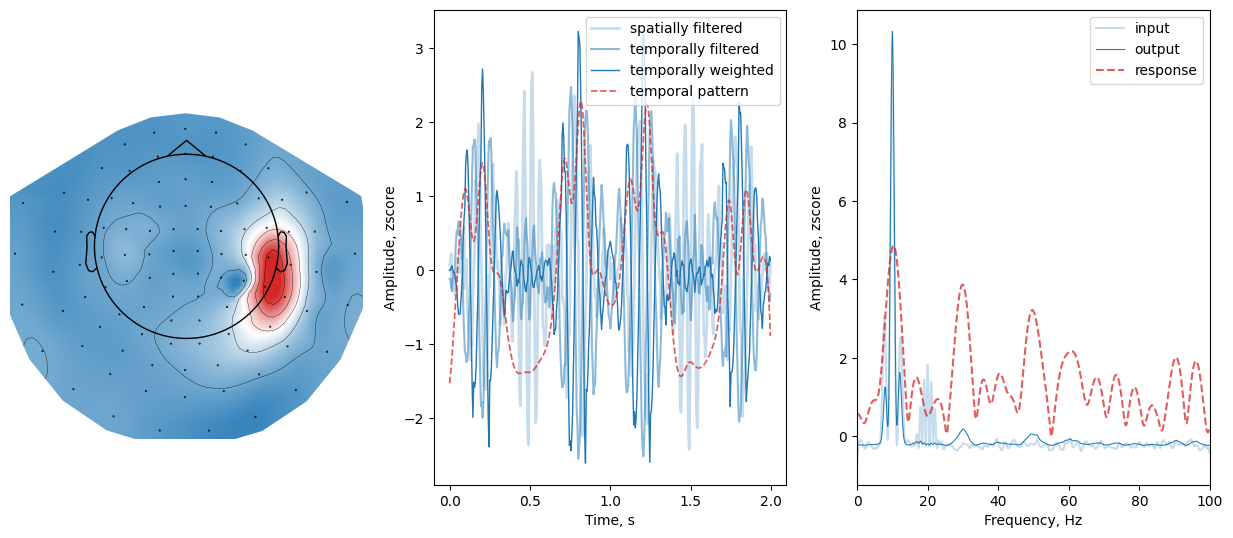

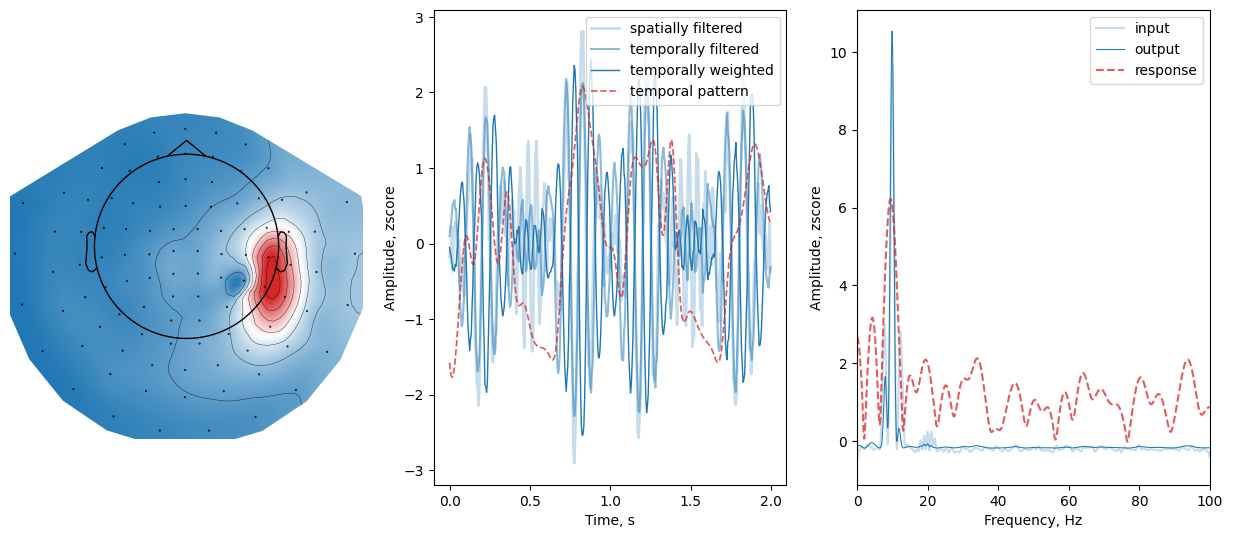

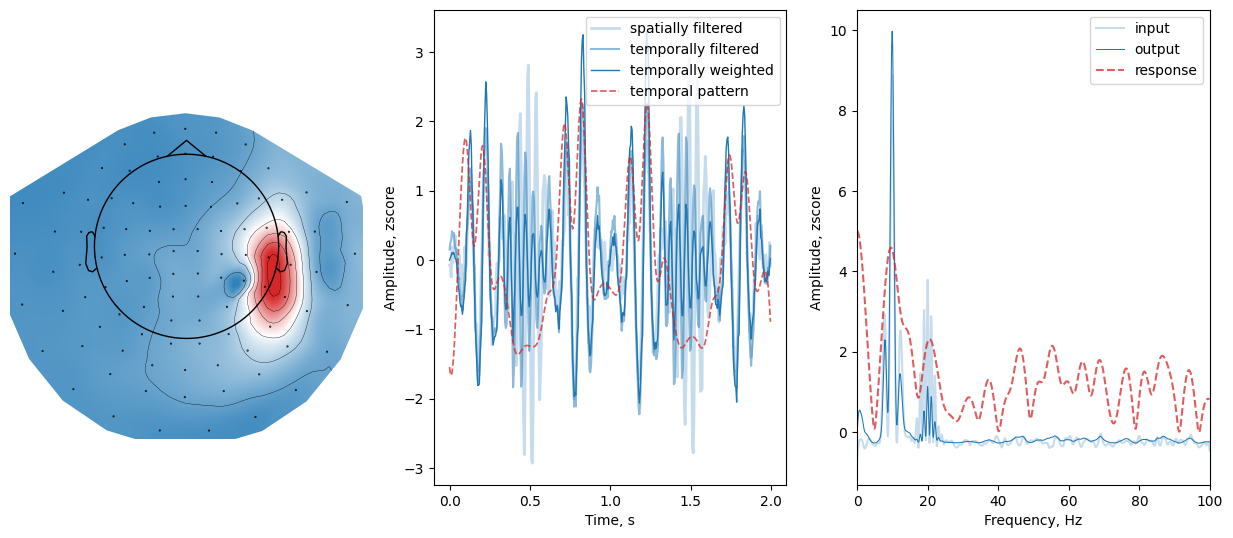

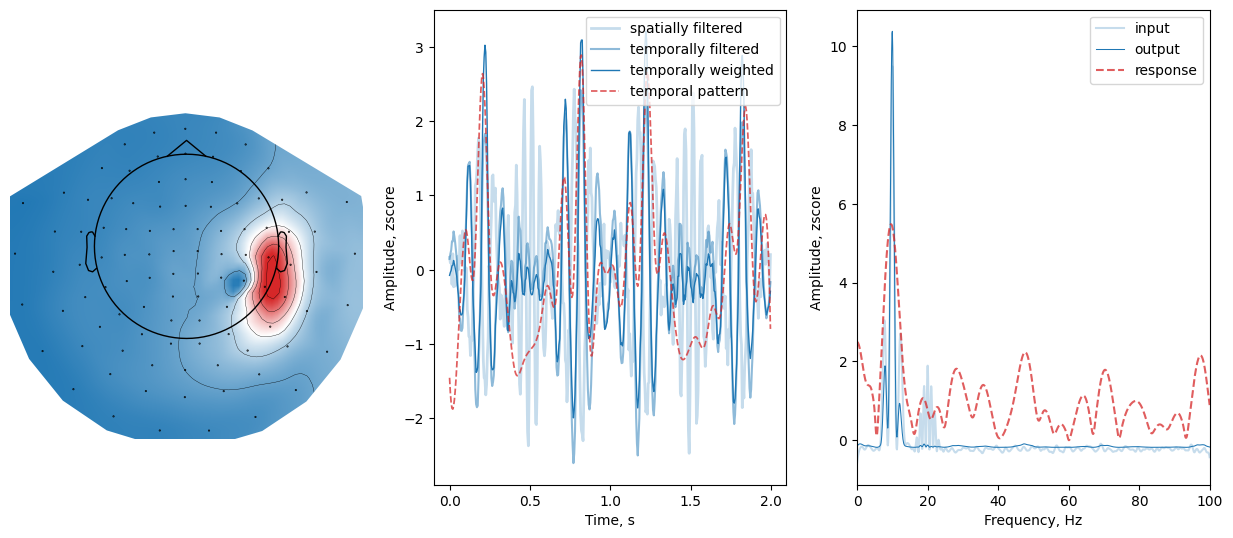

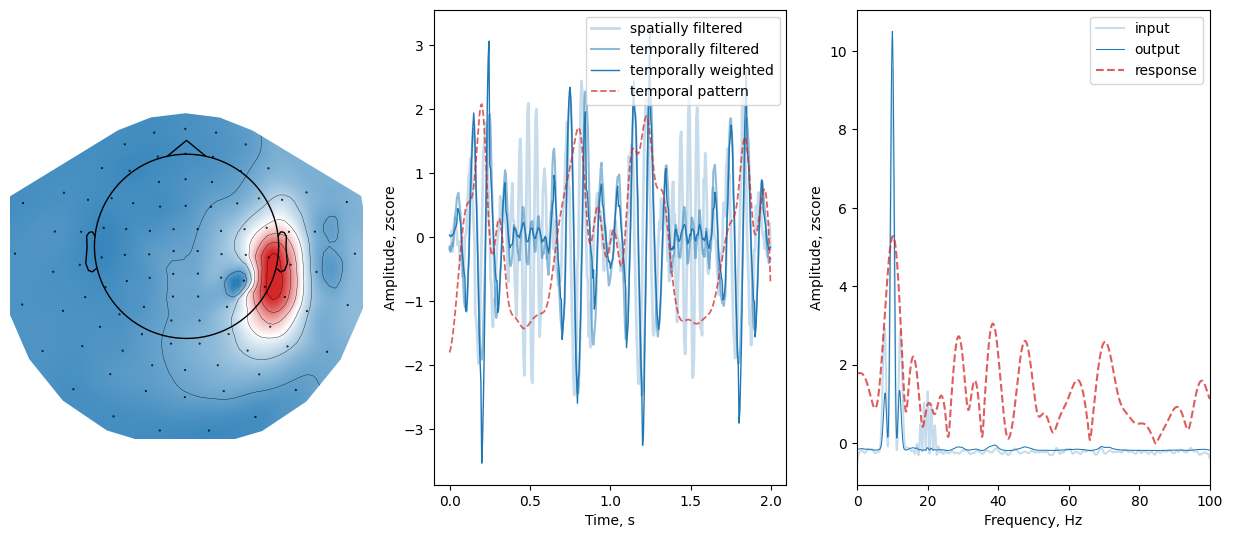

In [50]:
interpreter = SPIRITInterpreter(spirit, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

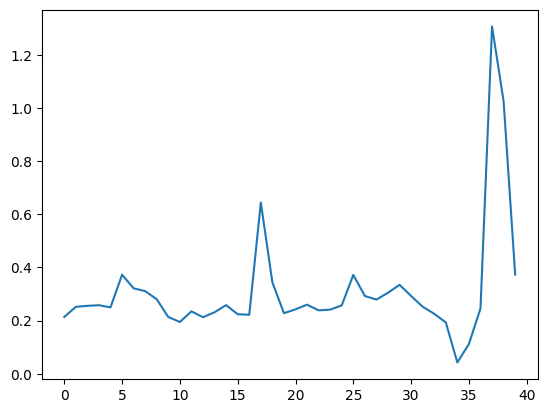

In [52]:
plt.plot(interpreter.temporal_patterns[0][0])
plt.show()